# Réalisez une veille technologique
## Sentence-BERT
OpenClassrooms - Parcours Data Scientist - Projet 08  

## Présentation du projet

**Contexte**  


* __Place de marché__ souhaite lancer une marketplace e-commerce anglophone  
* Les vendeurs proposent des articles à des acheteurs en postant une photo et une description  
* Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, elle est peu fiable. Le volume des articles est très petit  
* Il devient nécessaire d'automatiser la tâche d‘attribution de la catégorie  
* Une première étude de faisabilité à été réalisée à partir des descriptions d'une part (reprise dans ce notebook), et des images de l'autre

**Mission**  
* Réaliser un état de l’art sur une __technique récente de modélisation de données texte__ ou de données image, l’analyser, la tester et la comparer à une approche plus classique réalisée précédemment
* Le domaine du traitement du langage naturel (NLP) a connu ces dernières années des avancées significatives grâce à des modèles comme BERT et ses variantes. Ces modèles ont révolutionné les tâches de classification de texte, de réponse aux questions, et de similarité sémantique
* Le modèle __Sentence-BERT__, tel que présenté dans le papier ["Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks"](https://ar5iv.labs.arxiv.org/html/1908.10084), paraît particulièrement adapté à ce projet. Sa capacité à produire des embeddings de phrases riches et sémantiquement significatifs pourrait améliorer sensiblement les résultats, dans des délais raisonnables
* L'objectif de notebook est d'évaluer l'efficacité de __Sentence-BERT__ (avec quelques variantes pré-entraînées) pour la classification des descriptions des produits en catégories, en le comparant avec __CountVectorizer__, __TF-IDF__, __Word2Vec__ et __Universal Sentence Encoder__ (__USE__)

__Méthodologie__

1. **Prétraitement des Données** : Tokenization, lemmatization, bags-of-words, word embedding... selon le modèle implémenté
2. **Extraction des Embeddings** : Application des modèles pour obtenir les représentations vectorielles des descriptions
3. **Réduction de Dimensionnalité** : Utilisation de T-SNE pour représenter les embeddings en 2 dimensions
4. **Clustering** : Application de K-Means pour regrouper les produits en 7 clusters
5. **Évaluation des Modèles** : Utilisation du score ARI pour comparer les clusters générés aux catégories réelles des produits, calcul de la durée prétraitement + extraction des embeddings

## Préparation de l'environnement

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc8_note


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import tensorflow as tf
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import time
import shap
import textwrap

## Analyse rapide des données

### Chargement

In [3]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

### Extraction des variables pertinentes

__Variable cible__

In [4]:
# Création variable 'category' par récupération du texte entre '["' et la première occurence de ' >>'
df_datas['category'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

In [5]:
# Traduction
traduction = {
    'Home Furnishing': 'Ameublement',
    'Baby Care': 'Soins Bébés',
    'Watches': 'Montres',
    'Home Decor & Festive Needs': 'Décoration',
    'Kitchen & Dining': 'Cuisine',
    'Beauty and Personal Care': 'Beauté',
    'Computers': 'Informatique'
}

df_datas['category'] = df_datas['category'].replace(traduction)

In [6]:
y_true = df_datas['category']

__Variable d'input__

In [7]:
descriptions = df_datas['description']

### Analyse rapide

__Informations statistiques__

In [8]:
# Informations statistiques
df_datas[['description', 'category']].describe()

description     category
count                                                1050         1050
unique                                               1050            7
top     Key Features of Elegance Polyester Multicolor ...  Ameublement
freq                                                    1          150

__Répartition des produits__

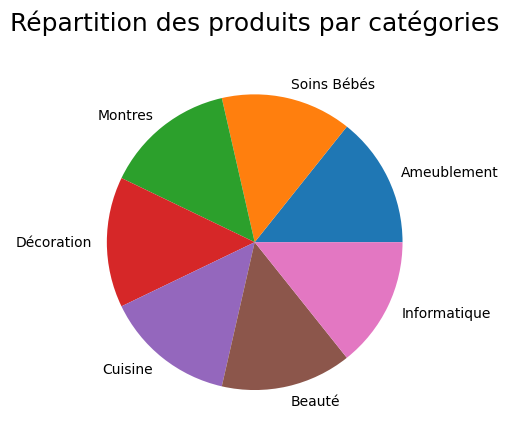

In [9]:
# Pieplot de répartition des produits par catégories
df_datas['category'].value_counts().plot(kind='pie')
plt.ylabel('')
plt.title('Répartition des produits par catégories', fontsize=18, pad=20)
plt.show()

__Longueurs des descriptions__

In [10]:
def count_words(description):
    return len(description.split())

In [11]:
df_datas['word_count'] = df_datas['description'].apply(count_words)
shortest_description = df_datas.loc[df_datas['word_count'].idxmin()]['description']
longest_description = df_datas.loc[df_datas['word_count'].idxmax()]['description']
total_descriptions = df_datas.shape[0]
total_words = df_datas['word_count'].sum()

In [12]:
# Affichage des résultats
print(f"Nombre de descriptions : {total_descriptions}")
print(f"Nombre total de mots : {total_words}")
print('--------------------------------------')
print(f"Description la plus courte ({df_datas['word_count'].min()} mots) :\n{shortest_description}")
print('--------------------------------------')
print(f"Description la plus longue ({df_datas['word_count'].max()} mots) :\n{longest_description}")

Nombre de descriptions : 1050
Nombre total de mots : 80013
--------------------------------------
Description la plus courte (13 mots) :
Next Steps Baby Girl's Layered Dress
                         Price: Rs. 356
				
			Girls Dress
Girls Dress
--------------------------------------
Description la plus longue (587 mots) :
Key Features of HomeEdge Solid Wood King Bed King Bed 72x78 Mattress Size 1 King Bed Natural Polish,HomeEdge Solid Wood King Bed (Finish Color -  Natural) Price: Rs. 18,799 Made to Order SolidWood Bed made by the finest artisans from Rajasthan. Bed is made to perfection. These Beds are handicraft products which are made to order by the manufacturer. Please make sure that this bed is ordered once you are aware of the entire product. Mattress Dimension of a Queen Size Bed will be 60inch x 78inch and Mattress Dimension of a King Bed will be 72inch x 78inch. Kindly check the mattress size before you order the bed. Also, the polish might have a slight variation as these a

__Nuage de mots__

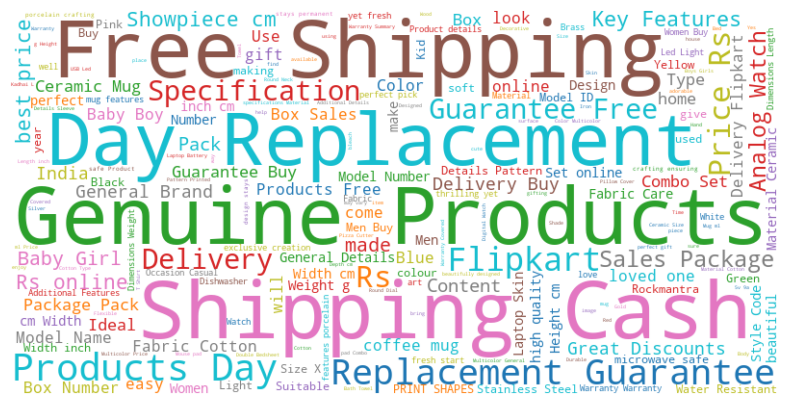

In [13]:
# Génération d'un nuage des mots les plus fréquents
text = ' '.join(description for description in df_datas['description'])

wordcloud = WordCloud(
    random_state = 2,
    width = 800,
    height = 400,
    background_color='white',
    colormap='tab10'
)

wordcloud.generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prétraitement

__Fonction de preprocessing__

In [14]:
def preprocess_text(text):
    # Conversion du texte en minuscules
    text = text.lower()
    
    # Tokenization du texte avec conservation des mots avec apostrophe et tiret
    pattern = r"\b[a-zA-Z\-\']+\b"
    tokenizer = RegexpTokenizer(pattern)
    words = tokenizer.tokenize(text)

    # Suppression des stop-words
    words = [word for word in words if word not in stop_words]

    # Application du POS tagging (POS = Part Of Speech)
    tagged_words = nltk.pos_tag(words)

    # Initialisation du lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatisation des noms communs et verbes
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag.startswith('NN'):  # Noms communs (NN, NNS)
            lemma = lemmatizer.lemmatize(word, pos='n')  # Version au singulier
        elif tag.startswith('VB'):  # Verbes (VB, VBD, VBG, VBN, VBP, VBZ)
            lemma = lemmatizer.lemmatize(word, pos='v')  # Version à l'infinitif
        else:
            continue
        lemmatized_words.append(lemma)

    # Suppression des mots de 2 lettres ou moins
    lemmatized_words = [word for word in lemmatized_words if len(word) >= 3]

    return lemmatized_words

__Tokens à exclure__

In [15]:
start_tokens_to_exclude = time.perf_counter()

# Liste de stop-words
nltk.download('stopwords', quiet=True)
stop_words = list(set(stopwords.words('english')))

# Tokens avec moins de 5 occurences sur l'ensemble du corpus
product_descriptions = ' '.join(df_datas['description'].values)
product_descriptions_words = preprocess_text(product_descriptions)
frequencies = pd.Series(product_descriptions_words).value_counts().reset_index()
words = frequencies.loc[frequencies['count'] < 5]
low_frequency_words = list(words['index'].values)

duration_tokens_to_exclude = time.perf_counter() - start_tokens_to_exclude

__Bags of words__

In [16]:
# Création des bags of word
def bag_of_words(document):
    bow = preprocess_text(document)
    bow = ' '.join([token for token in bow if token not in low_frequency_words])
    return bow

In [17]:
start_bags_of_words = time.perf_counter()

# Création variable 'bag of words'
df_datas['bag of words'] = df_datas['description'].apply(bag_of_words)

duration_bags_of_words = time.perf_counter() - start_bags_of_words

## Initialisation des modèles

In [18]:
# Dictionnaire pour stocker les modèles
models = {}

__CountVectorizer__

In [19]:
models['CountVectorizer'] = CountVectorizer()

__TF-IDF__

In [20]:
models['TF-IDF'] = TfidfVectorizer()

__Word2Vec__

In [21]:
start_bow_fe_w2v = time.perf_counter()
sentences = [document.split() for document in df_datas['bag of words']]
models['Word2Vec'] = Word2Vec(sentences, vector_size=100, window=6, min_count=1, epochs=30, workers=4)
duration_bow_fe_w2v = (time.perf_counter() - start_bow_fe_w2v) + duration_bags_of_words

__Universal Sentence Encoder (USE)__

In [22]:
import tensorflow_hub as hub
models['Universal Sentence Encoder'] = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

__Sentence-BERT__

In [23]:
pre_trained_models = ['all-mpnet-base-v2', 'all-distilroberta-v1', 'all-MiniLM-L6-v2', 'paraphrase-albert-small-v2']
for sbert_model in pre_trained_models:
    sbert_model_name = 'Sentence-BERT (' + sbert_model + ')'
    models[sbert_model_name] = SentenceTransformer(sbert_model, trust_remote_code=True)

## Feature extraction

In [24]:
# Dictionnaire pour stocker les métriques
metrics = {
    'Modèle': list(models.keys()),
    'Durée': [],
    'Score ARI': []
}

# Dictionnaire pour stocker les représentations vectorielles des descriptions
embeddings = {}

__CountVectorizer__

In [25]:
start = time.perf_counter()
embeddings['CountVectorizer'] = models['CountVectorizer'].fit_transform(df_datas['bag of words']).toarray()
metrics["Durée"].append((time.perf_counter() - start) + duration_tokens_to_exclude + duration_bags_of_words)

__TF-IDF__

In [26]:
start = time.perf_counter()
embeddings['TF-IDF'] = models['TF-IDF'].fit_transform(df_datas['bag of words']).toarray()
metrics["Durée"].append((time.perf_counter() - start) + duration_tokens_to_exclude + duration_bags_of_words)

__Word2Vec__

In [27]:
start = time.perf_counter()
embeddings['Word2Vec'] = np.array([np.mean([models['Word2Vec'].wv[word] for word in words if word in models['Word2Vec'].wv] or [np.zeros(100)], axis=0) for words in sentences])
metrics["Durée"].append((time.perf_counter() - start) + duration_bow_fe_w2v)

__Universal Sentence Encoder (USE)__

In [28]:
start = time.perf_counter()
embeddings['Universal Sentence Encoder'] = models['Universal Sentence Encoder'](descriptions)
metrics["Durée"].append(time.perf_counter() - start)

__Sentence-BERT__

In [29]:
for sbert_model in pre_trained_models:
    sbert_model_name = 'Sentence-BERT (' + sbert_model + ')'
    start = time.perf_counter()
    embeddings[sbert_model_name] = models[sbert_model_name].encode(descriptions)
    metrics["Durée"].append(time.perf_counter() - start)

## Réduction de dimension T-SNE

In [30]:
# Dictionnaire pour stocker les composantes T-SNE
t_sne = {}

In [31]:
random_state = 96
tsne = TSNE(n_components=2, random_state=random_state)

In [32]:
for model, embed in embeddings.items():
    t_sne[model] = tsne.fit_transform(embed)

## Clustering KMeans

In [33]:
# Dictionnaire pour stocker les clusters
clusters = {}

In [34]:
# 7 catégories -> 7 clusters
kmeans = KMeans(n_clusters=7, random_state=random_state)

In [35]:
for model, components in t_sne.items():
    clusters[model] = kmeans.fit_predict(components)

## Évaluations ARI

In [36]:
# Dictionnaire pour stocker les scores ARI
ari = {}

In [37]:
for model, y_pred in clusters.items():
    ari[model] = adjusted_rand_score(y_true, y_pred)
    metrics['Score ARI'].append(ari[model])

In [38]:
best_ari_score = max(metrics['Score ARI'])

## Synthèse des résultats

In [39]:
df_metrics = pd.DataFrame(metrics)
df_metrics["Durée"] = round(df_metrics["Durée"], 2)
df_metrics["Score ARI"] = round(df_metrics["Score ARI"], 2)

In [40]:
display(df_metrics)

Modèle   Durée  Score ARI
0                             CountVectorizer    8.02       0.43
1                                      TF-IDF    8.02       0.47
2                                    Word2Vec    4.43       0.31
3                  Universal Sentence Encoder    0.79       0.45
4           Sentence-BERT (all-mpnet-base-v2)  216.17       0.70
5        Sentence-BERT (all-distilroberta-v1)  135.90       0.53
6            Sentence-BERT (all-MiniLM-L6-v2)   29.31       0.72
7  Sentence-BERT (paraphrase-albert-small-v2)   71.50       0.47

## Visualisations

In [41]:
def format_duration(seconds):
    if seconds < 1:
        milliseconds = seconds * 1000
        return f"{milliseconds:.0f} ms"
    elif seconds < 60:
        whole_seconds = int(round(seconds, 0))
        return f"{whole_seconds} sec"
    else:
        minutes = int(seconds // 60)
        remaining_seconds = seconds % 60
        whole_seconds = int(round(remaining_seconds, 0))
        return f"{minutes} mn {whole_seconds} sec"

In [42]:
def plot_clusters(X, y_pred, model_name, results):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{model_name}', fontsize=16, fontweight='bold')

    for i, label in enumerate([('Catégories prédites', y_pred), ('Catégories réelles', y_true)]):
        title, hue = label
        sns.scatterplot(x=X[:,0], y=X[:,1], hue=hue, palette='bright', alpha=0.6, ax=ax[i])
        ax[i].set_title(title, fontweight='bold', pad=10)
        ax[i].set_xlabel('Composante t-sne 1') #, fontweight='bold')
        if i == 0:
            ax[i].set_ylabel('Composante t-sne 2') #, fontweight='bold')
        
        # Suppression xticks et yticks
        ax[i].tick_params(left=False, bottom=False)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].legend(prop={'size': 7})

        # Fixer les limites des axes pour tous les graphiques
        ax[i].set_xlim(-60, 70)

    ax[2].set_title('Résultats', fontweight='bold', pad=10)
    ax[2].tick_params(left=False, bottom=False)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].text(0.5, 0.8, "Score ARI", horizontalalignment='center')
    color = "limegreen" if results['Score ARI'].values[0] > (best_ari_score - 0.001) else 'darkgray'
    ax[2].text(0.5, 0.6, f"{results['Score ARI'].values[0]:.2f}", horizontalalignment='center', fontweight='bold', fontsize=50, color=color)
    
    ax[2].text(0.5, 0.35, "Prétraitement + Feature extraction", horizontalalignment='center')
    duration = format_duration(results["Durée"].values[0])
    ax[2].text(0.5, 0.2, duration, horizontalalignment='center', fontsize=35, color='darkgray')

    plt.subplots_adjust(wspace=1)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

__Répartition des produits par catégories et métriques__

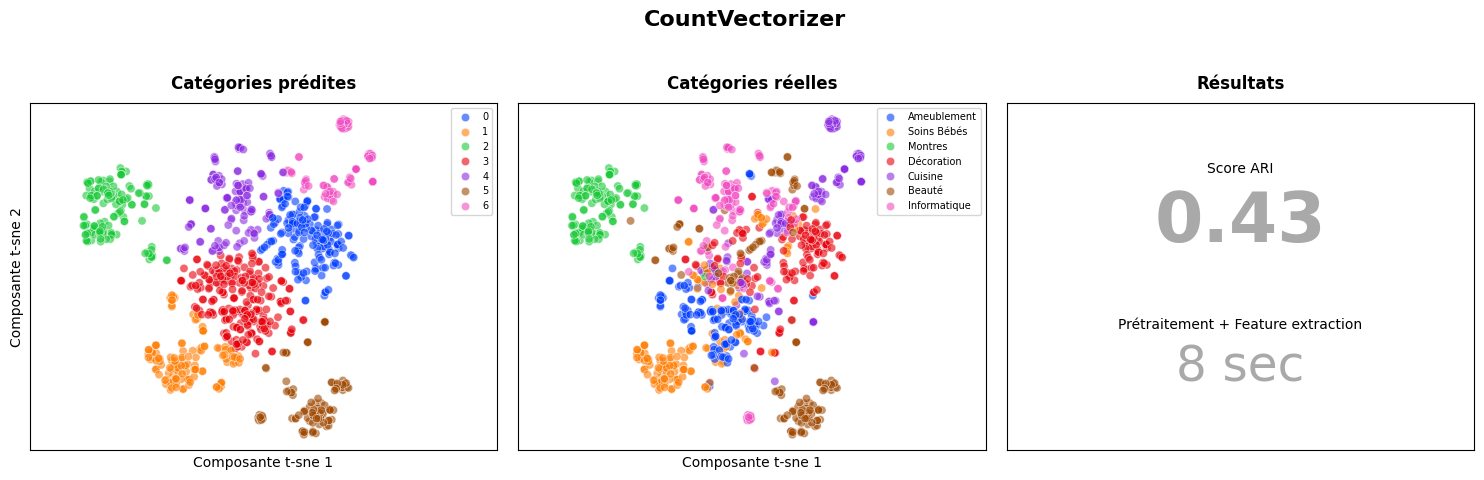

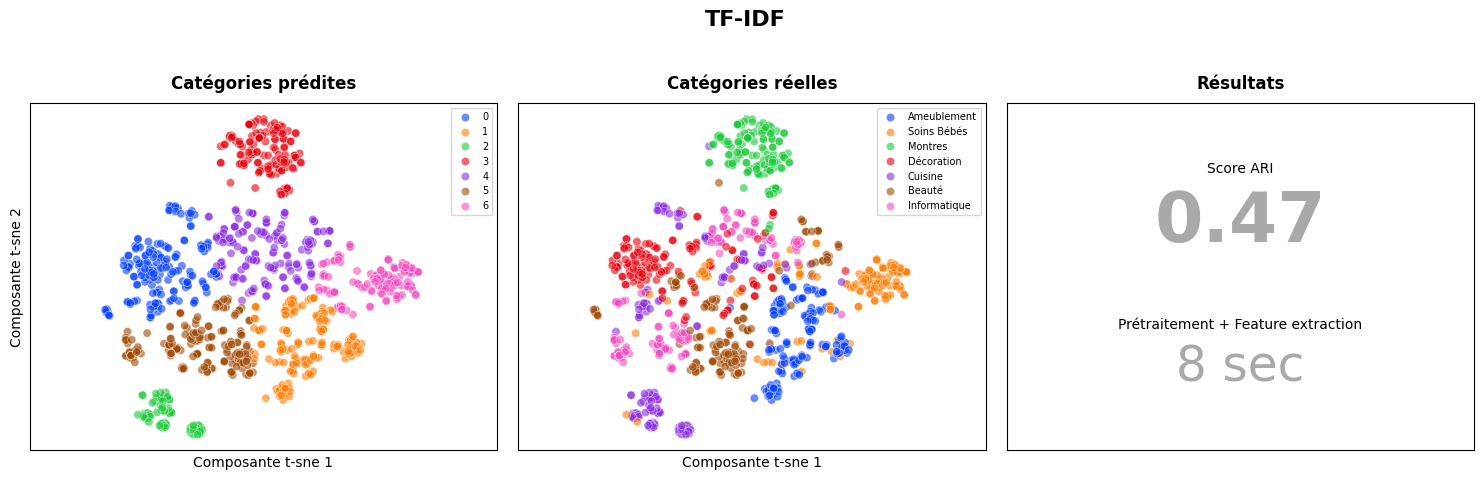

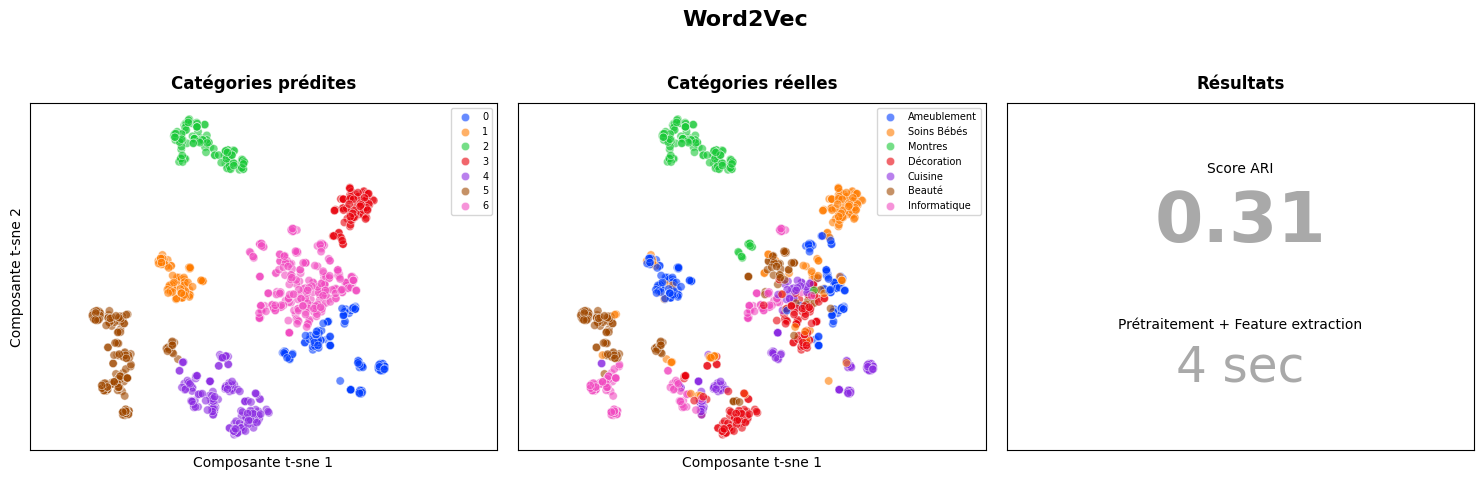

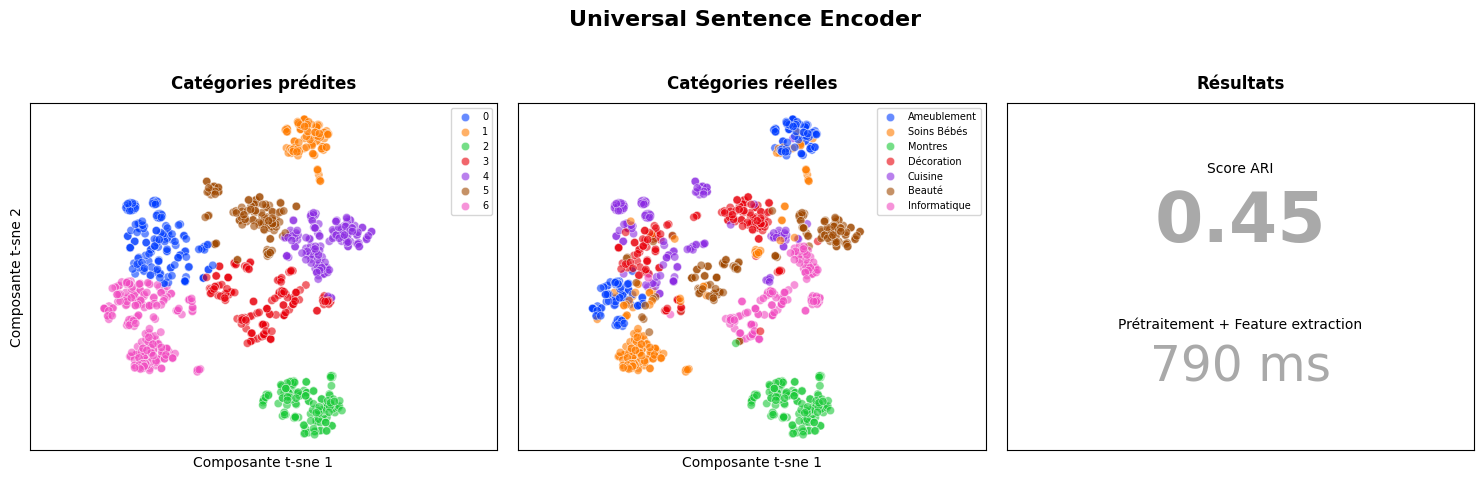

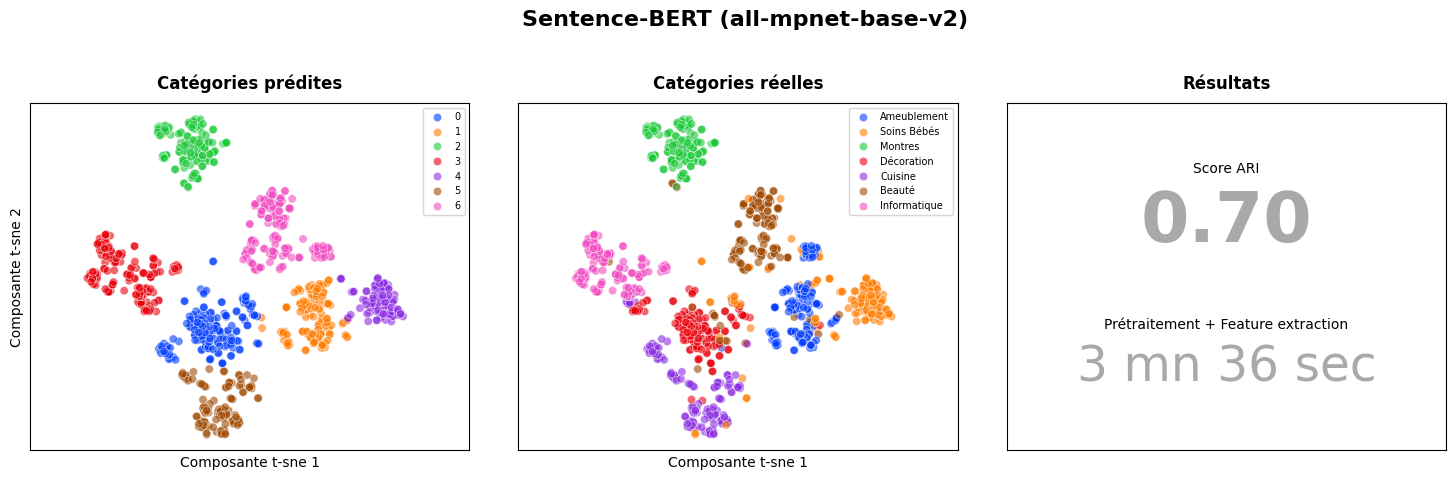

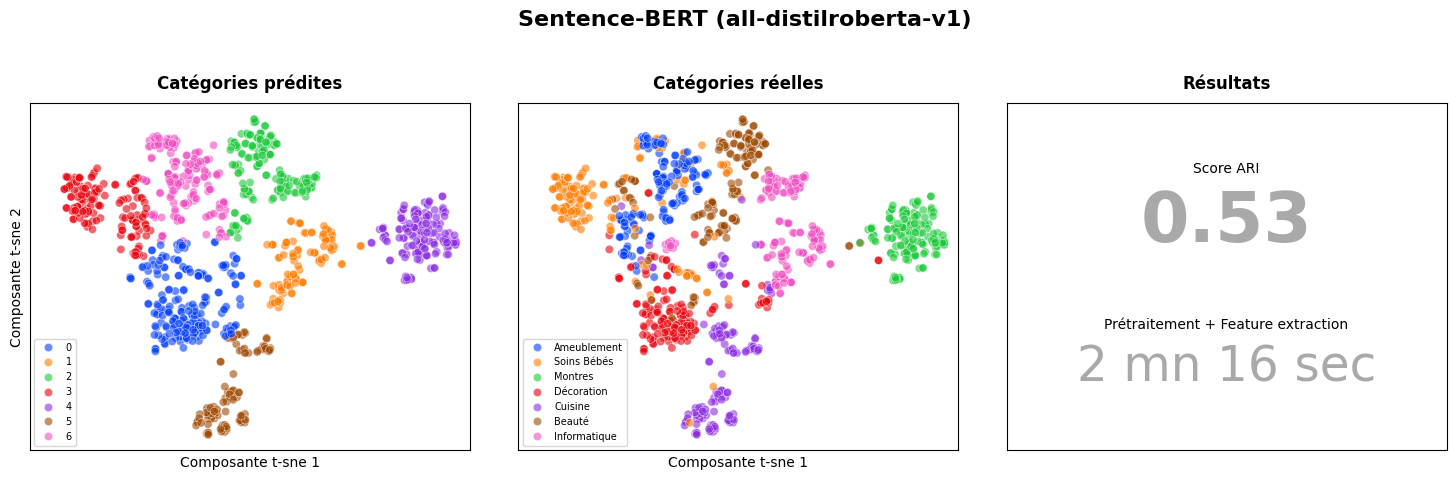

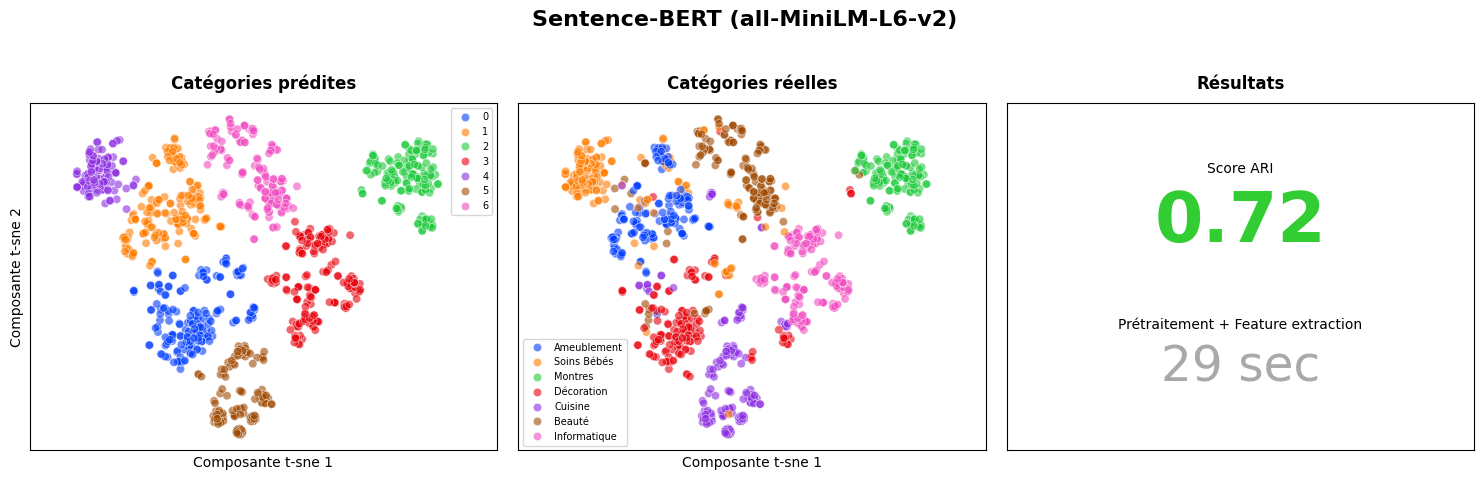

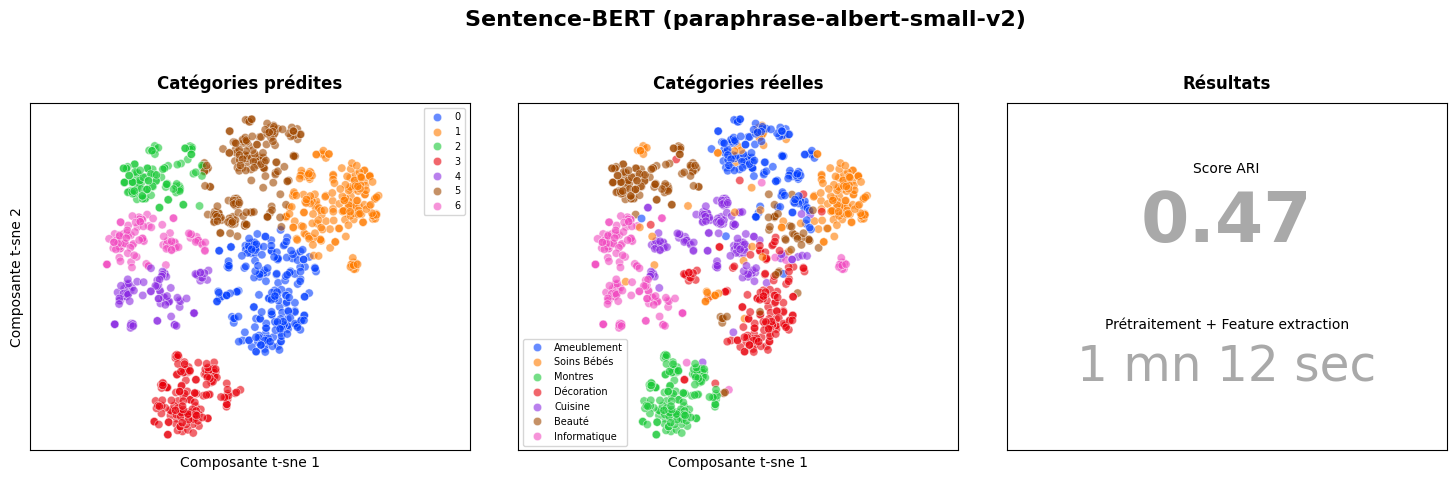

In [43]:
for model, components in t_sne.items():
    results = df_metrics.loc[df_metrics['Modèle'] == model]
    plot_clusters(components, clusters[model], model, results)
    print()
    print()

__Comparaison graphique des métriques__

In [44]:
df_metrics_sorted = df_metrics.sort_values(by='Score ARI', ascending=True)

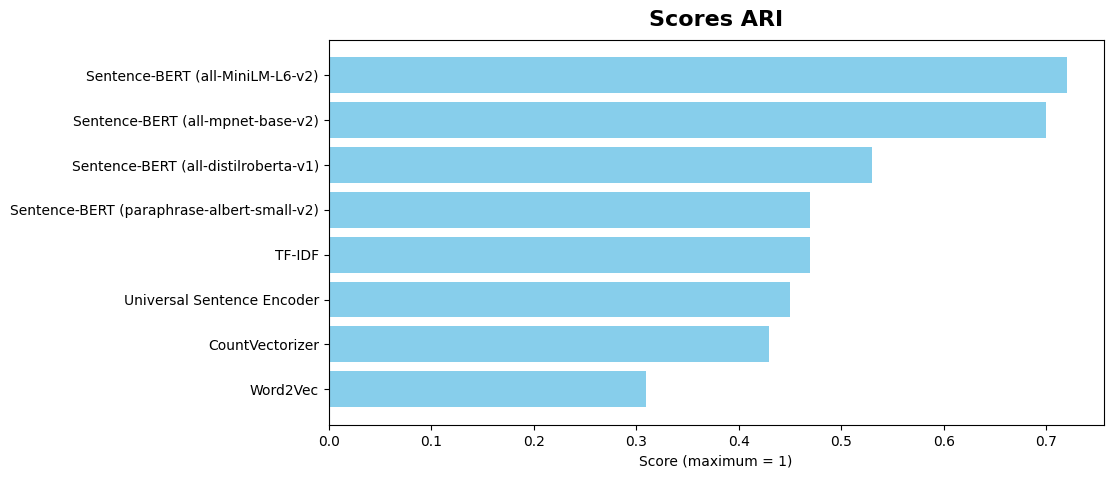

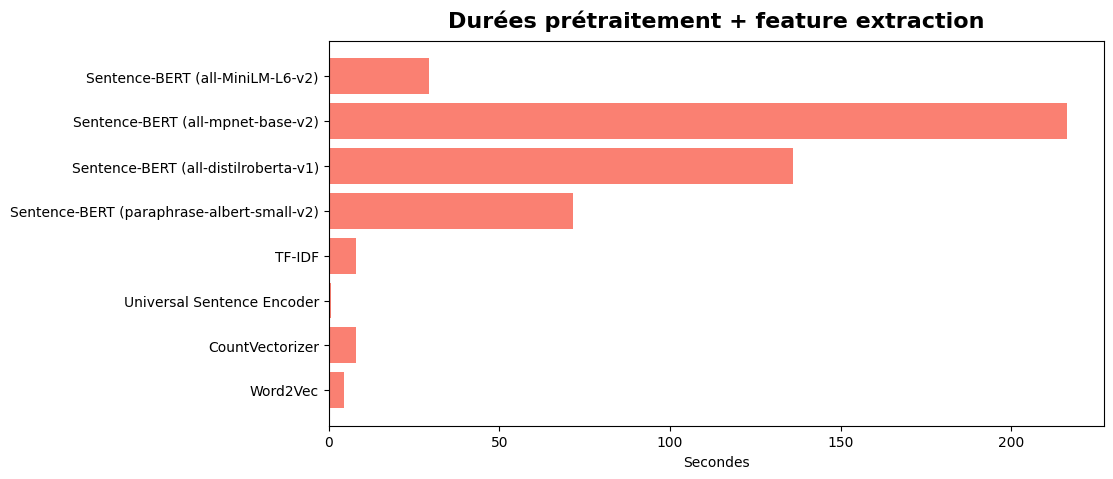

In [45]:
# Barplot scores ARI
plt.figure(figsize=(10, 5))
plt.barh(df_metrics_sorted['Modèle'], df_metrics_sorted['Score ARI'], color='skyblue')
plt.xlabel('Score (maximum = 1)')
plt.ylabel('')
plt.title('Scores ARI', fontsize=16, fontweight='bold', pad=10)
plt.show()
print()

# Barplot durées
plt.figure(figsize=(10, 5))
plt.barh(df_metrics_sorted['Modèle'], df_metrics_sorted['Durée'], color='salmon')
plt.xlabel('Secondes')
plt.ylabel('')
plt.title('Durées prétraitement + feature extraction', fontsize=16, fontweight='bold', pad=10)
plt.show()

## LogisticRegression

Le score ARI de __0.72__ obtenu via Sentence-BERT pré-entrainé avec 'all-MiniLM-L6-v2' laisse imaginer la possibilité des prédictions correctes à partie des embeddings générés.  

Dans le cadre de ce "proof of concept", le modèle __LogisticRegression__ est utilisé car il présente les avantages suivants :  
* permet une classification multi-classes (il y a 7 catégories de produits)  
* adapté aux données de grande dimension (les embeddings générés sont des vecteurs de 384 features)  
* rapide à entraîner
* compatible avec la librairie SHAP pour les calculs de Feature importance

__Prédictions__

In [46]:
# Encodage des categories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_datas['category'])

# Jeu d'entraînement / jeu de test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(embeddings['Sentence-BERT (all-MiniLM-L6-v2)'], y, df_datas.index, test_size=0.2, random_state=96)

# Classification
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

__Accuracy__

In [47]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")

Accuracy : 0.9666666666666667


## Feature Importance

__Feature importance globale__

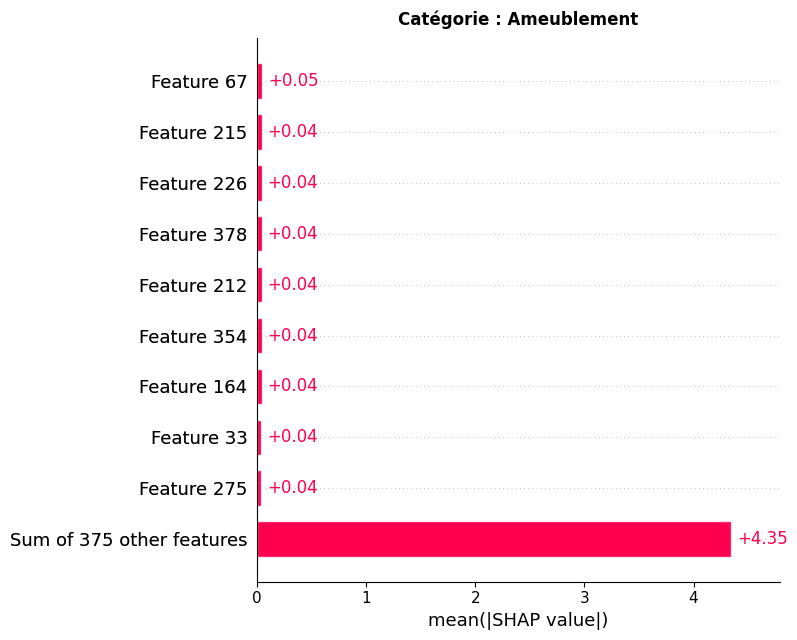

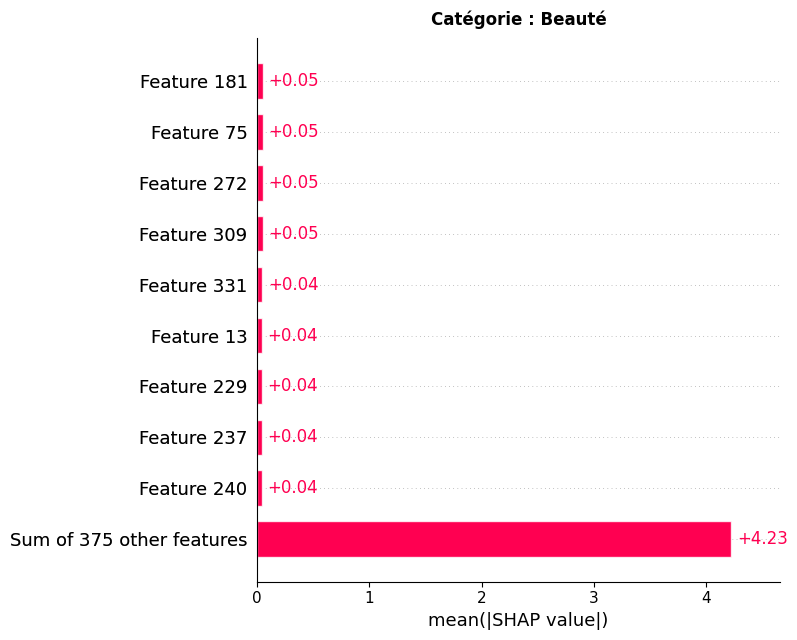

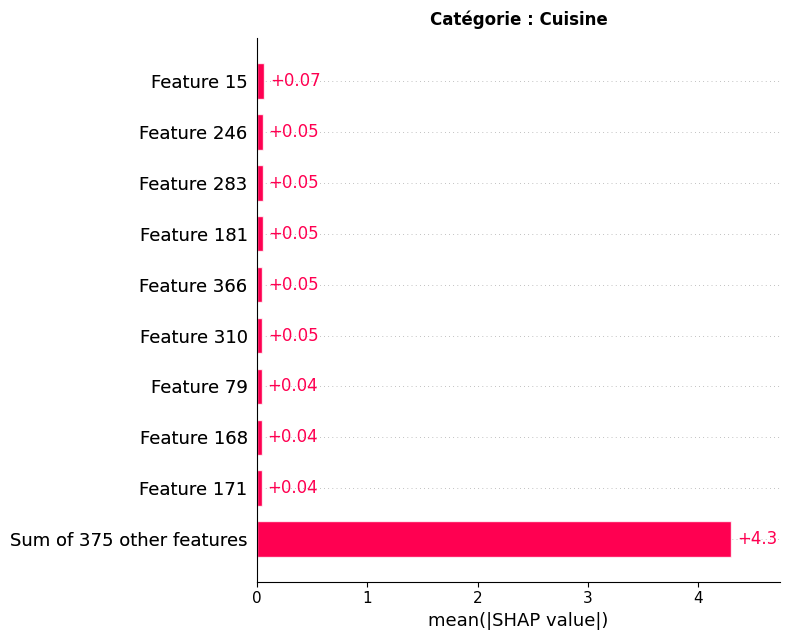

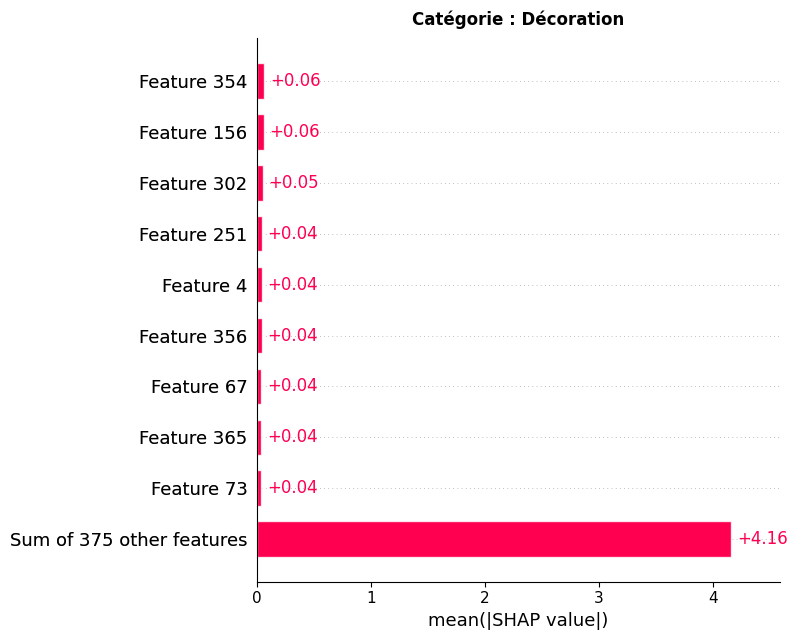

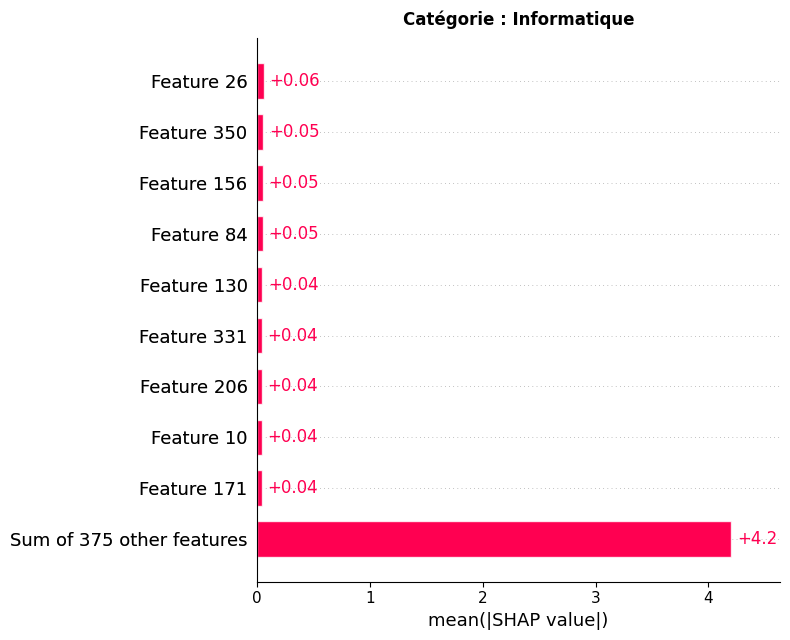

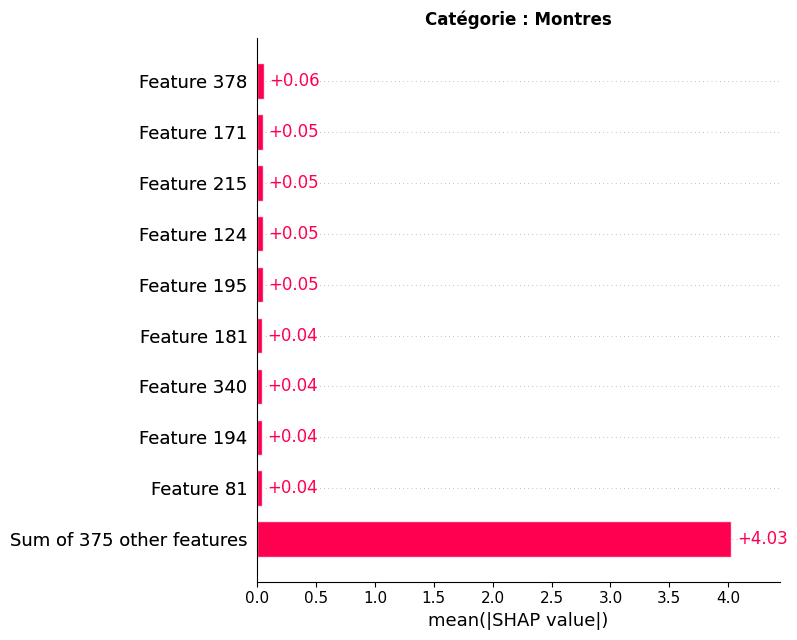

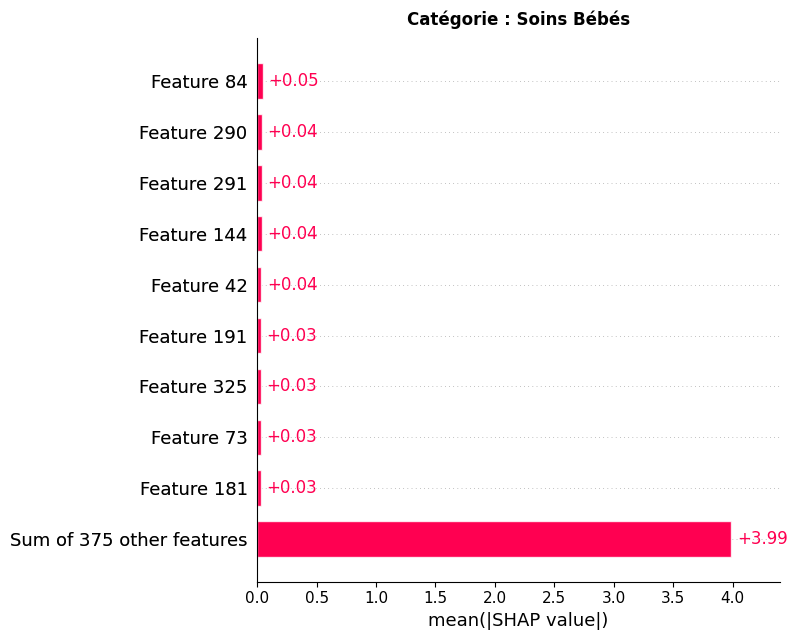

In [48]:
# Initialisation de l'explainer SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Récupération des noms de catégorie à partir des labels
label_to_category = {index: label for index, label in enumerate(label_encoder.classes_)}

# BarPlot pour chaque catégorie
for class_index in range(shap_values.shape[2]):
    plt.figure()
    shap.plots.bar(shap_values[:,:,class_index], show=False)
    plt.title(f"Catégorie : {label_to_category[class_index]}", fontweight='bold', pad=10)
    plt.tight_layout()
    plt.show()
    print()

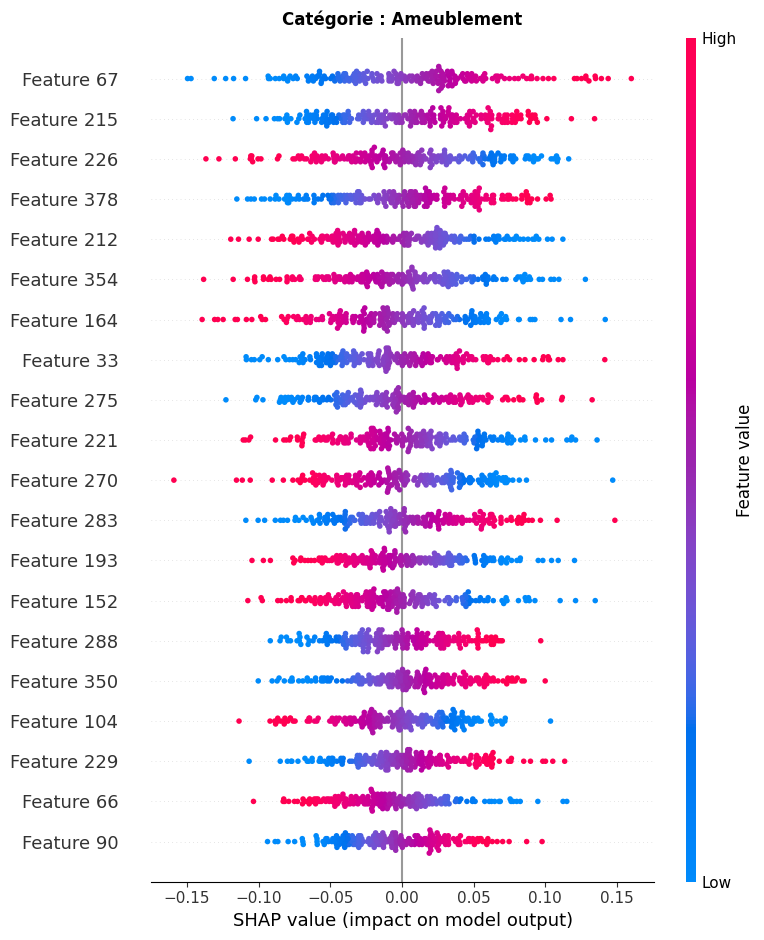

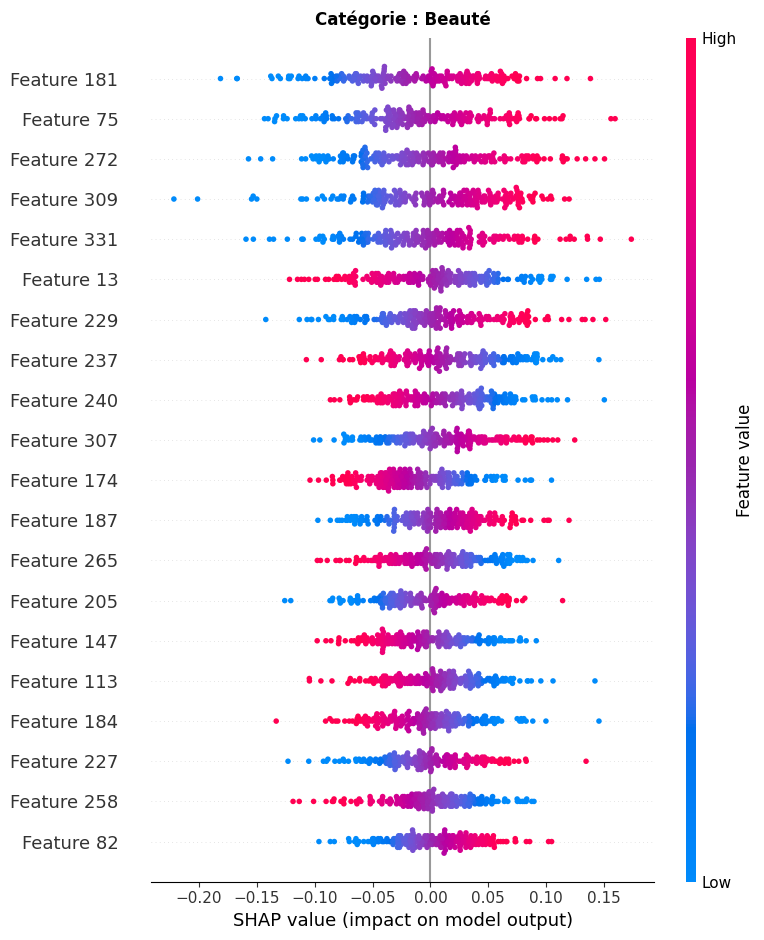

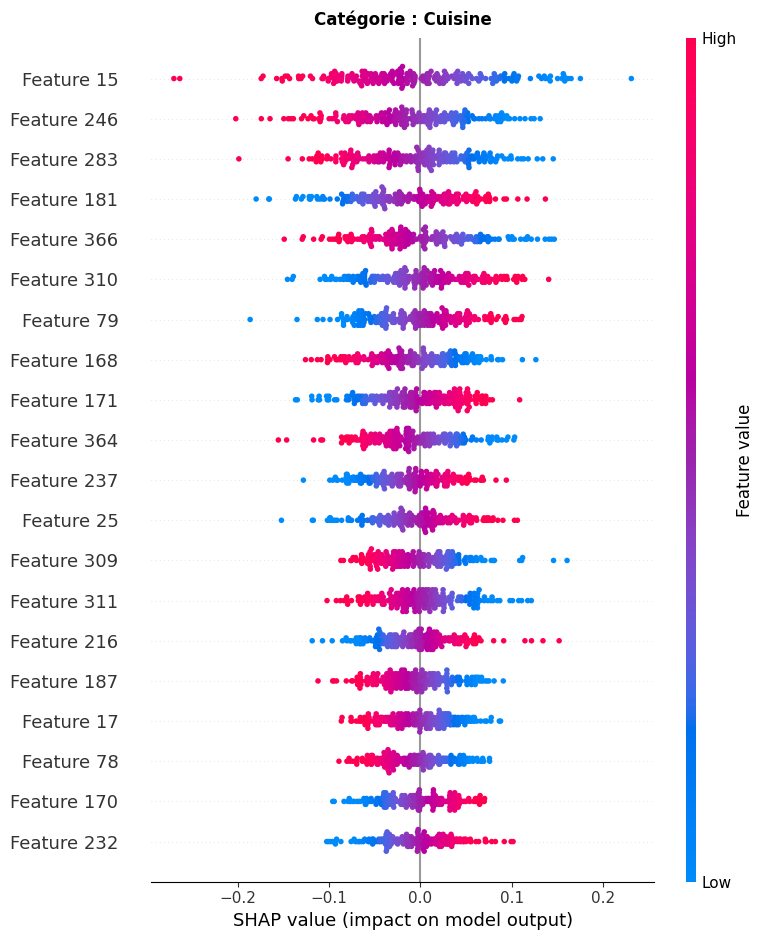

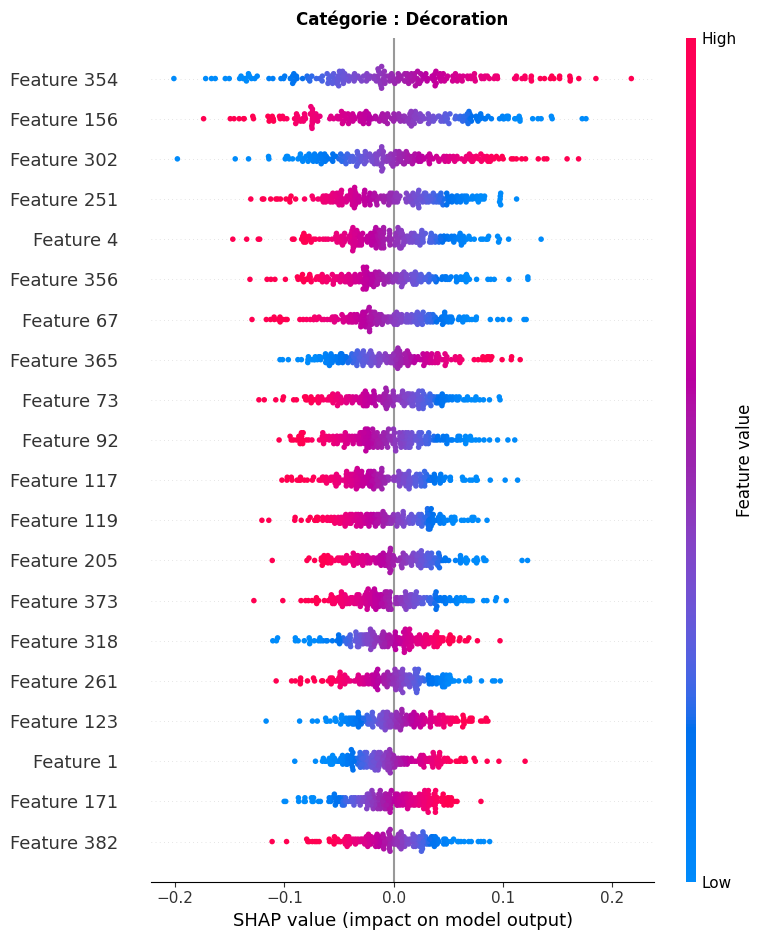

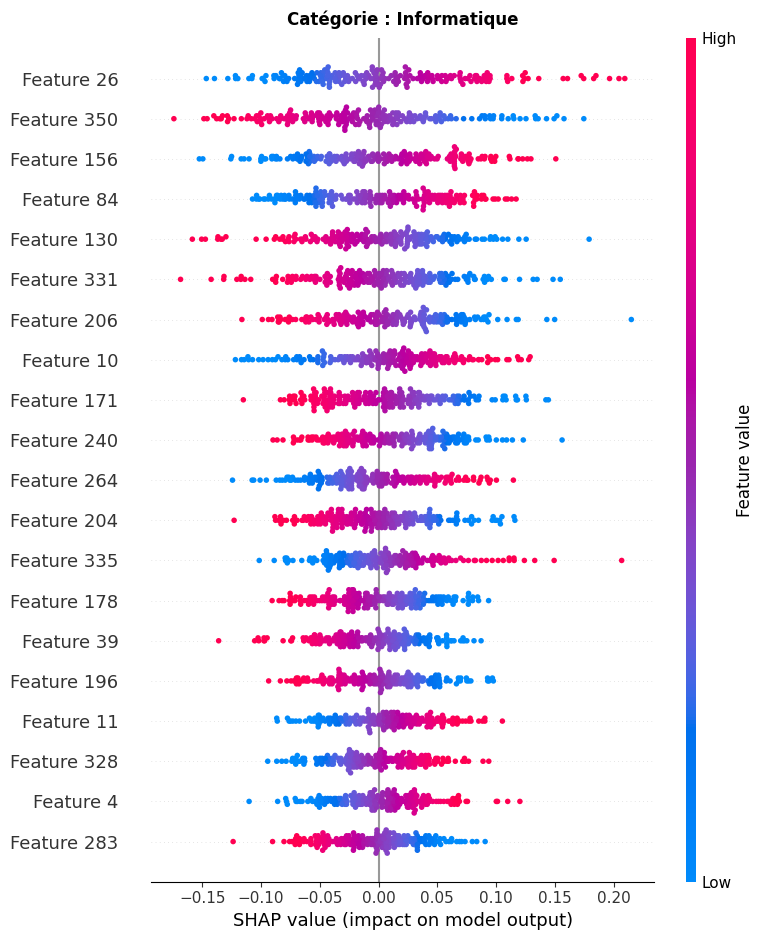

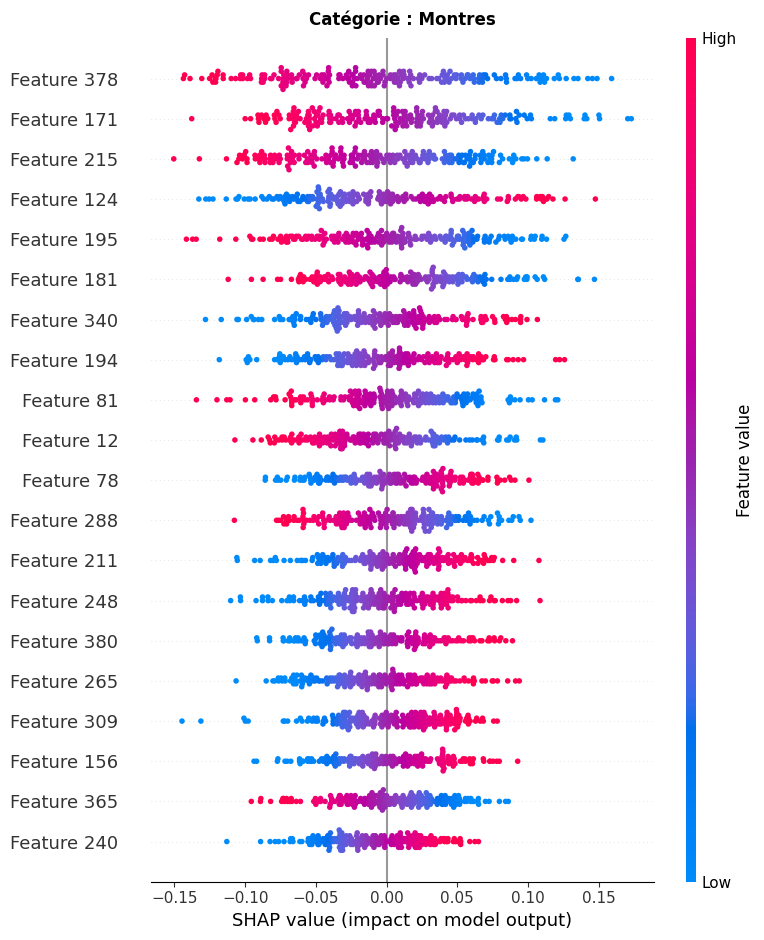

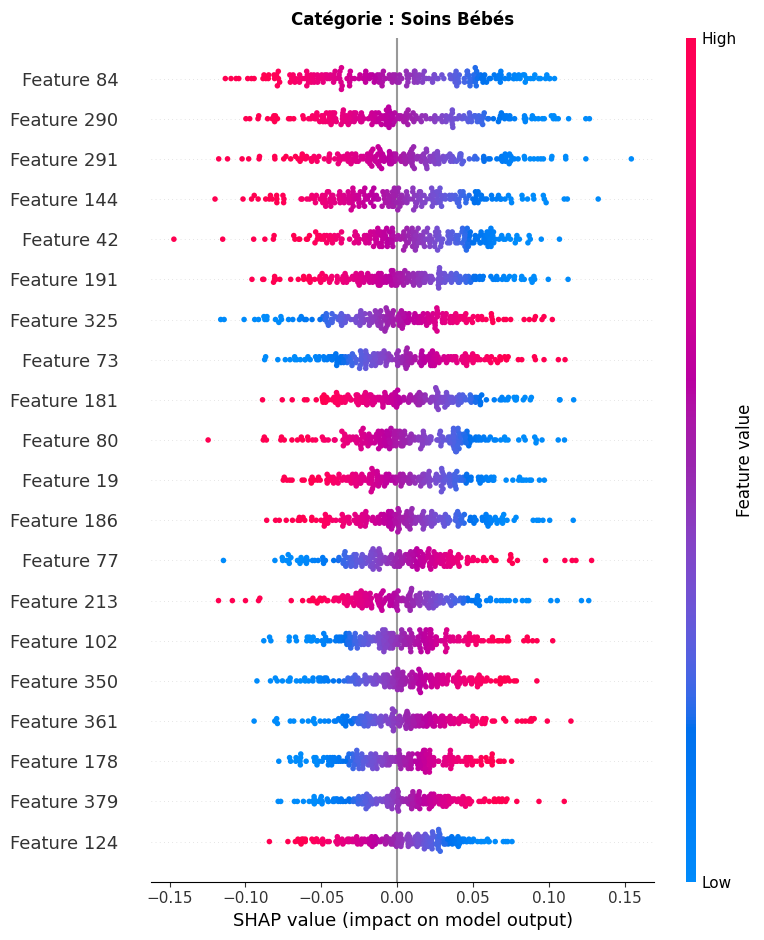

In [49]:
# SummaryPlot pour chaque catégorie
for class_index in range(shap_values.shape[2]):
    plt.figure()
    shap.summary_plot(shap_values[:, :, class_index], X_test, show=False)
    plt.title(f"Catégorie : {label_to_category[class_index]}", fontweight='bold', pad=10)
    plt.tight_layout()
    plt.show()
    print()

__Feature importance locale__

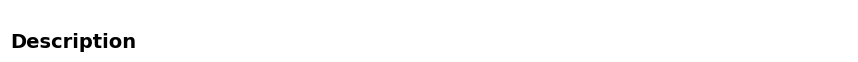

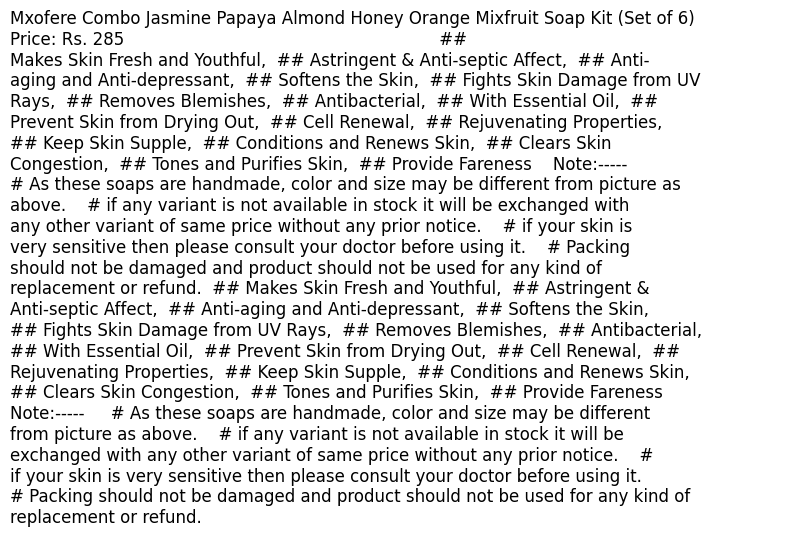

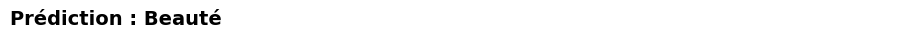

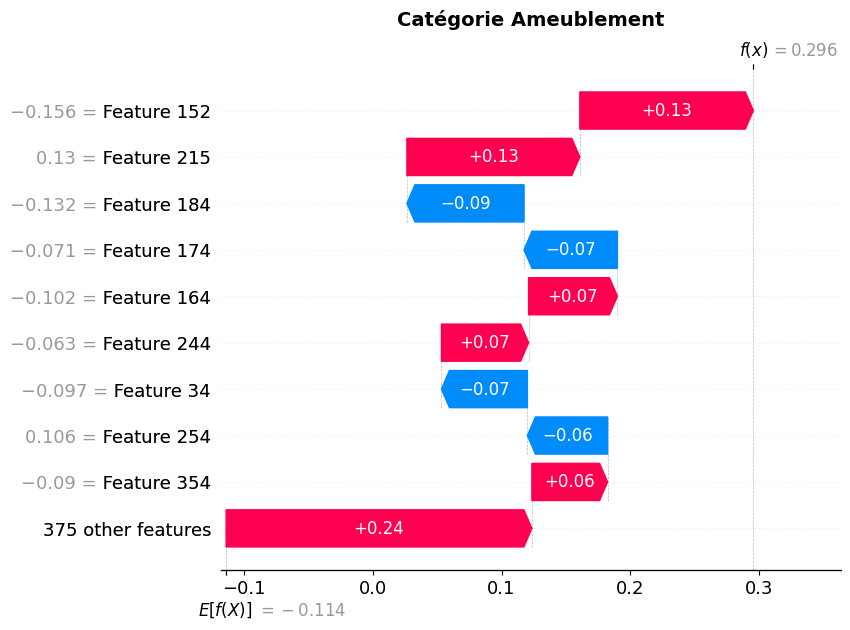

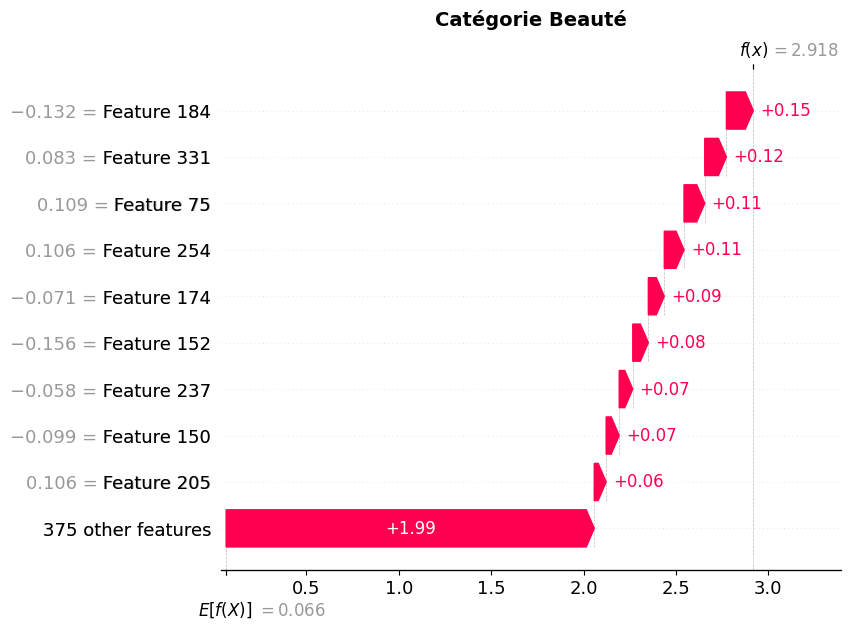

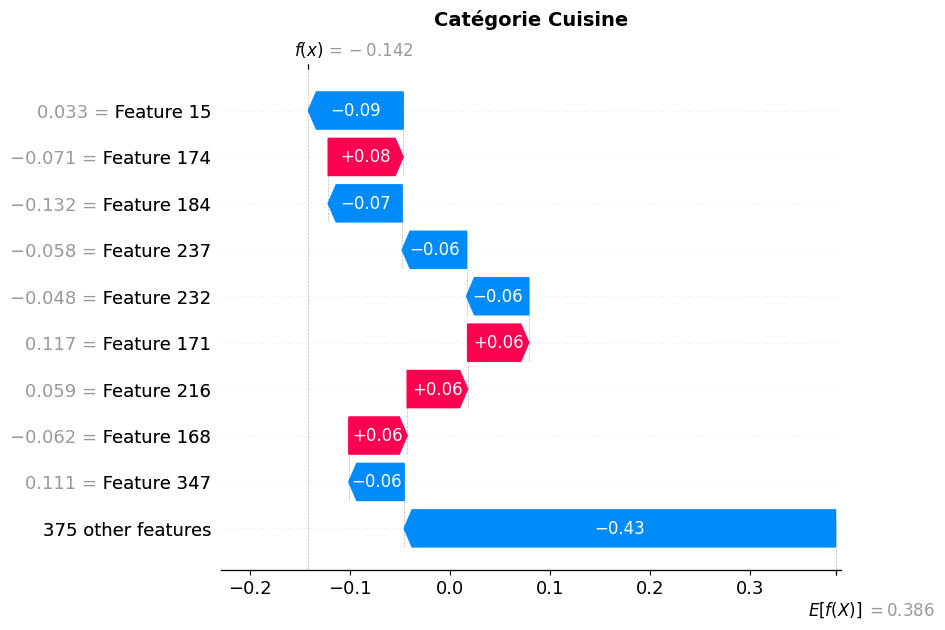

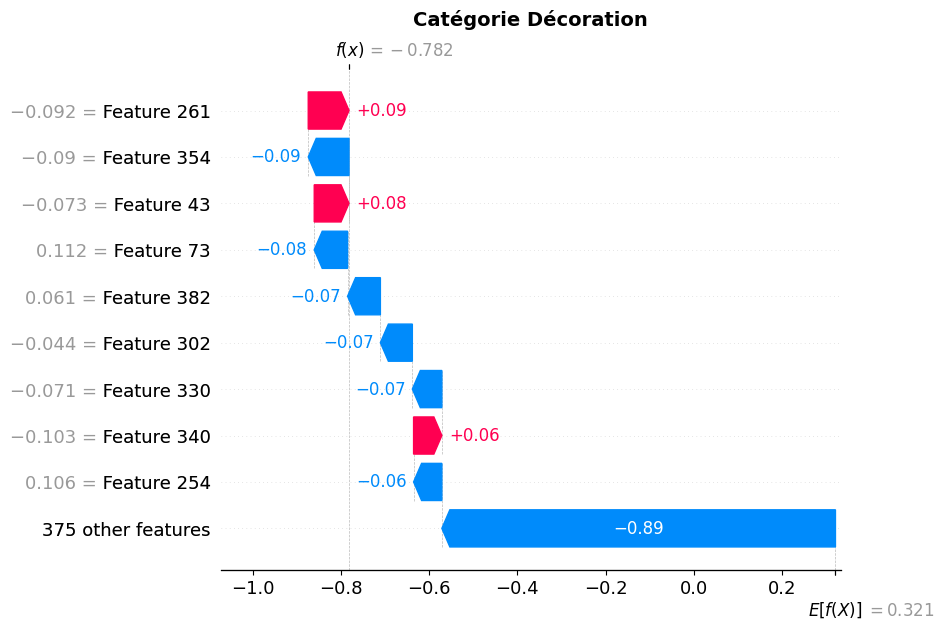

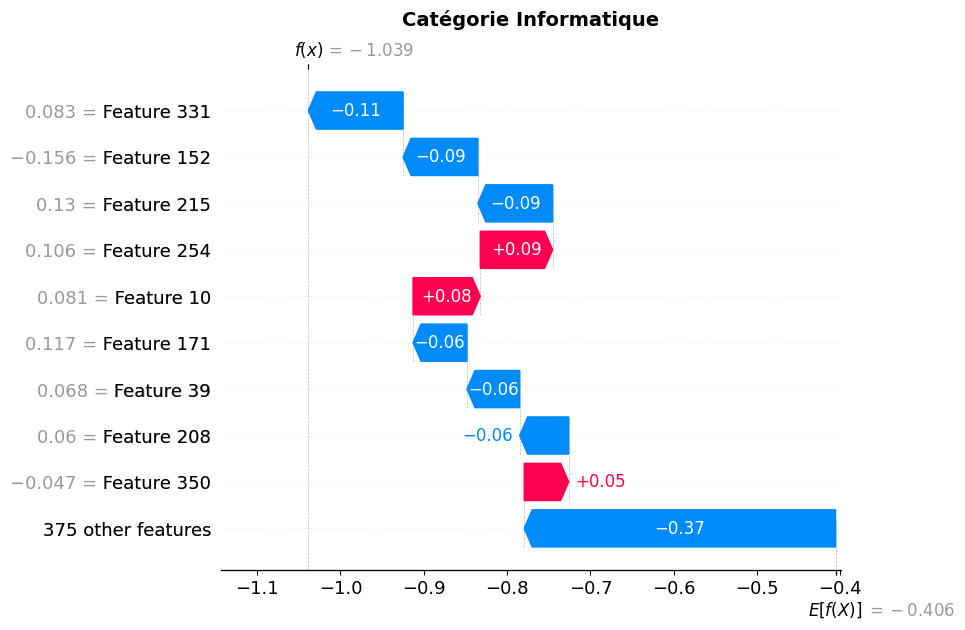

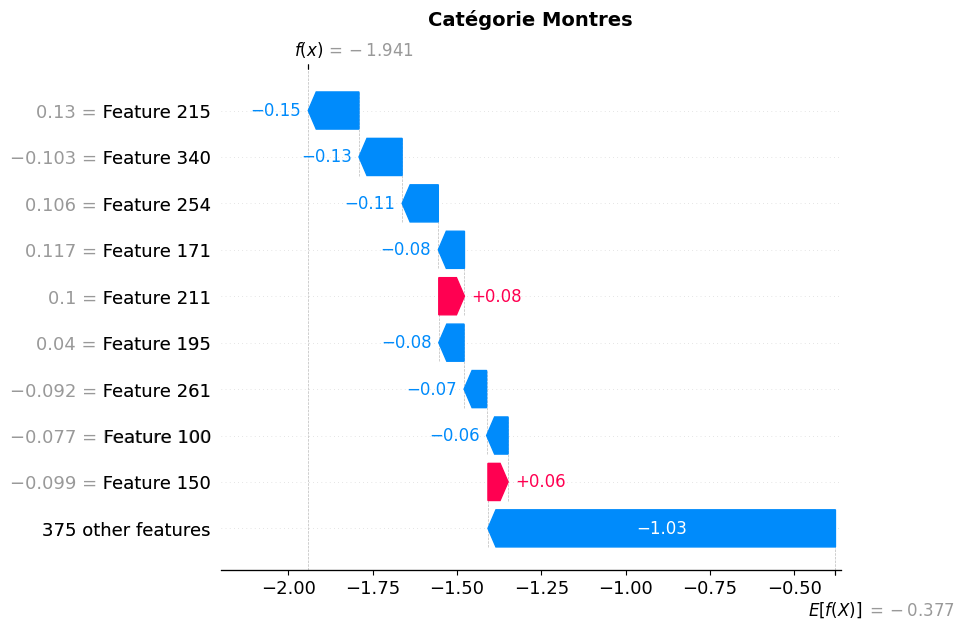

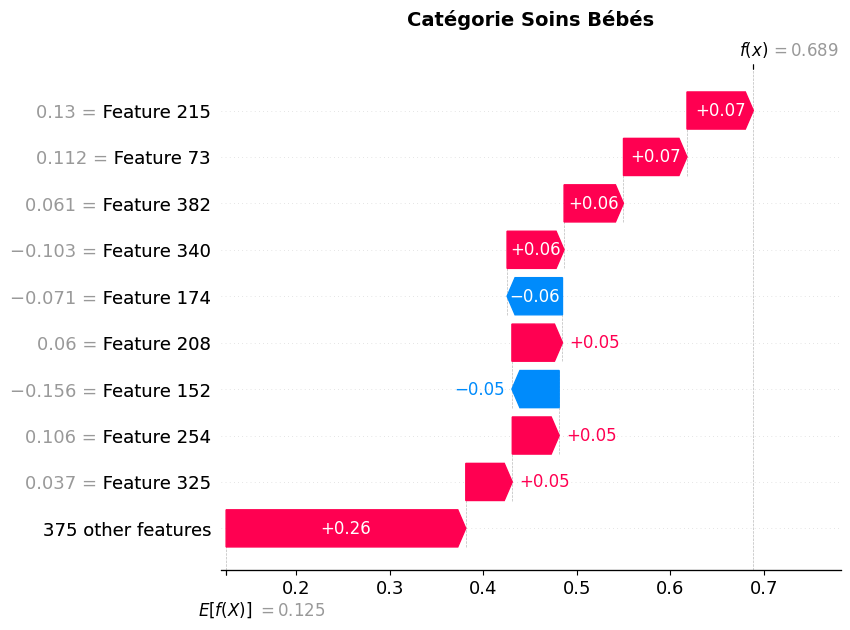

In [128]:
test_index = 7
pred_label = y_test[test_index]

original_index = indices_test[test_index]
product_description = df_datas.loc[original_index, 'description']

wrapper = textwrap.TextWrapper(width=79)  
desc = wrapper.fill(text=product_description) 

# Description produit
plt.figure(figsize=(10, 0.5))
plt.text(0, 0, "Description", ha='center', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 0.1))
plt.text(0, 0, desc, ha='left', va='center', fontsize=12)
plt.axis('off')
plt.show()

# Prédiction
plt.figure(figsize=(10, 0.1))
plt.text(0, 0, f"Prédiction : {label_to_category[pred_label]}", ha='center', va='center', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
print()

# WaterfallPlots par catégorie
for num_category in range(7):
    plt.figure()
    shap.plots.waterfall(shap_values[test_index][:, num_category], show=False)
    title = f"Catégorie {label_to_category[num_category]}"
    plt.title(title, fontweight='bold', fontsize=14, pad=10)
    plt.show()